In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pylab as plt
import copy

import sys
sys.path.append("..")

from fdfdpy import Simulation
from structures import three_port, two_port
from optimization import Optimization

%load_ext autoreload
%autoreload 2
%matplotlib inline

Computed a domain with 190 grids in x and 130 grids in y
The simulation has 20 grids per free space wavelength


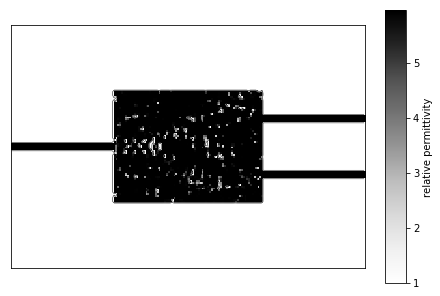

In [6]:
eps_r = np.load('../data/MM_eps_3port.npy')
lambda0 = 2e-6              # free space wavelength (m)
c0 = 3e8                    # speed of light in vacuum (m/s)
omega = 2*np.pi*c0/lambda0  # angular frequency (2pi/s)
dl = 1.0e-1                 # grid size (L0)
NPML = [15, 15]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')
source_amp = 10             # amplitude of modal source (A/L0^2?)
# material constants
n_index = 2.44              # refractive index
eps_m = n_index**2          # relative permittivity
chi3 = 4.1*1e-19            # Al2S3 from Boyd (m^2/V^2)
max_ind_shift = 5.8e-3      # maximum allowed nonlinear refractive index shift (computed from damage threshold)
# geometric parameters
L = 8         # length of box (L0)
H = 6         # height of box (L0)
w = .4        # width of waveguides (L0)
d = 3         # distance between waveguides (L0)
l = 4         # length of waveguide from PML to box (L0)
spc = 2       # space between box and PML (L0)
# define permittivity of three port system
(_, design_region) = three_port(L, H, w, d, l, spc, dl, NPML, eps_m)
(Nx, Ny) = eps_r.shape
nx, ny = int(Nx/2), int(Ny/2)            # halfway grid points

simulation = Simulation(omega,eps_r,dl,NPML,pol)
# compute the grid size the total grid size
print("Computed a domain with {} grids in x and {} grids in y".format(Nx,Ny))
print("The simulation has {} grids per free space wavelength".format(int(lambda0/dl/simulation.L0)))
simulation.plt_eps()
plt.show()

In [10]:
# top modal profile
top = Simulation(omega, eps_r, dl, NPML, 'Ez')
top.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny+int(d/2/dl)], int(H/2/dl))
top.setup_modes()
J_top = np.abs(top.src)

# bottom modal profile
bot = Simulation(omega, eps_r, dl, NPML, 'Ez')
bot.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny-int(d/2/dl)], int(H/2/dl))
bot.setup_modes()
J_bot = np.abs(bot.src)

In [12]:
# This cell was ran with the old master

import autograd.numpy as npa
import time
from utils import Binarizer

nl_region = copy.deepcopy(design_region)
# set the modal source and probes
simulation = Simulation(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny], int(H/2/dl), scale=5)
simulation.setup_modes()
simulation.add_nl(chi3, nl_region, eps_scale=True, eps_max=eps_m)

def J(e, e_nl, eps):
    return npa.sum(npa.square(npa.abs(e))*J_top)*npa.sum(npa.square(npa.abs(e_nl))*J_bot)

binarizer = Binarizer(design_region, eps_m)
J_bin = binarizer.density(J)
# make optimization object and check derivatives
optimization = Optimization(J=J_bin, Nsteps=50, eps_max=eps_m)
# check the derivatives (note, full derivatives are checked, linear and nonlinear no longer separate)
(grad_avm, grad_num) = optimization.check_deriv(simulation, design_region, Npts=4)
print('adjoint gradient   = {}\nnumerical gradient = {}'.format(grad_avm, grad_num))

ti = time.time()
optimization.run(simulation, design_region, method='lbfgs')
print("Optimization runtime:", time.time()-ti)

adjoint gradient   = [630.8895715202966, 2245.4821283494475, 215.26320737666214, 2918.9734300451228]
numerical gradient = [621.5818715281785, 2217.848486965522, 215.1188274146989, 2854.0104177081957]


 ObjectiveFn: 7.26e+05 Iteration:  49/50 ETA:   0:00:09                        

Optimization runtime: 554.961688041687


In [14]:
ofs1 = optimization.objfn_list
print(ofs1)

[725247.2680638601, 725276.0651489284, 725279.3308100599, 725285.7716792773, 725295.4538264156, 725299.8245923826, 725305.753022843, 725317.1278085071, 725334.9233449779, 725360.2485065383, 725389.0291237427, 725408.0919552174, 725410.4872896303, 725416.1887993854, 725421.7488891522, 725433.8006992433, 725453.6081112559, 725454.9108033881, 725464.5463194051, 725471.7773541161, 725490.5837375509, 725503.3575819449, 725504.0410072621, 725535.3447229359, 725555.7727183127, 725583.6997313126, 725589.8237043238, 725592.2617494286, 725595.5270016759, 725619.1773973246, 725628.3280751834, 725631.7574115341, 725647.8456179012, 725682.521828048, 725704.2374568566, 725708.9791489668, 725713.432475722, 725721.3051330912, 725767.6246583739, 725774.2445221078, 725816.2472008644, 725827.8896759981, 725837.5320710702, 725840.1368062014, 725865.4804443674, 725873.523165721, 725880.5149380646, 725884.3403577476, 725922.7335830096, 725939.6914186089]


In [41]:
# This is with the new stuff
eps_r = np.load('../data/MM_eps_3port.npy')
simulation = Simulation(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny], int(H/2/dl), scale=5)
simulation.setup_modes()
simulation.add_nl(chi3, nl_region, eps_scale=True, eps_max=eps_m)

def J(e, e_nl, eps):
    return npa.sum(npa.square(npa.abs(e))*J_top)*npa.sum(npa.square(npa.abs(e_nl))*J_bot)

binarizer = Binarizer(design_region, eps_m)
J_bin = binarizer.density(J)
# make optimization object and check derivatives
optimization = Optimization(J=J_bin, Nsteps=50, eps_max=eps_m)
# check the derivatives (note, full derivatives are checked, linear and nonlinear no longer separate)
(grad_avm, grad_num) = optimization.check_deriv(simulation, design_region, Npts=4)
print('adjoint gradient   = {}\nnumerical gradient = {}'.format(grad_avm, grad_num))

ti = time.time()
optimization.run(simulation, design_region, method='lbfgs')
print("Optimization runtime:", time.time()-ti)

adjoint gradient   = [2084.321469462844, 124.92914322756019, 577.3770803617158, 130.67334129069195]
numerical gradient = [2039.8357049562037, 124.80510445311666, 546.4471171144396, 128.33084329031408]


 ObjectiveFn: 7.26e+05 Iteration:  49/50 ETA:   0:00:03                        

Optimization runtime: 209.75565576553345


In [43]:
ofs2 = optimization.objfn_list
print(ofs2)

[725276.0651487323, 725279.3308100502, 725285.7716789923, 725295.4538264137, 725299.8245924296, 725305.7530229118, 725317.1278083969, 725334.9233446922, 725360.2485064344, 725389.0291234998, 725408.0919551661, 725410.4872896442, 725416.1887994814, 725421.7488891142, 725433.8006993104, 725453.6081116069, 725454.9108037706, 725464.5463260604, 725471.7773850776, 725490.5833637526, 725503.3571440264, 725504.0407183941, 725535.3447563872, 725555.7794426956, 725583.7172704509, 725589.8457208324, 725592.2935641811, 725595.585030291, 725618.9810858029, 725628.1101210691, 725631.5120102145, 725639.737628108, 725686.337607892, 725704.3772930638, 725706.274004986, 725728.4441544622, 725730.1574780879, 725733.4645936381, 725770.6250147277, 725790.8120670706, 725792.2306598215, 725833.9705327846, 725845.5456890072, 725851.4094858846, 725854.8563849094, 725872.9421724229, 725888.4600360817, 725925.0494931865, 725934.9139455957, 725943.6489072052]


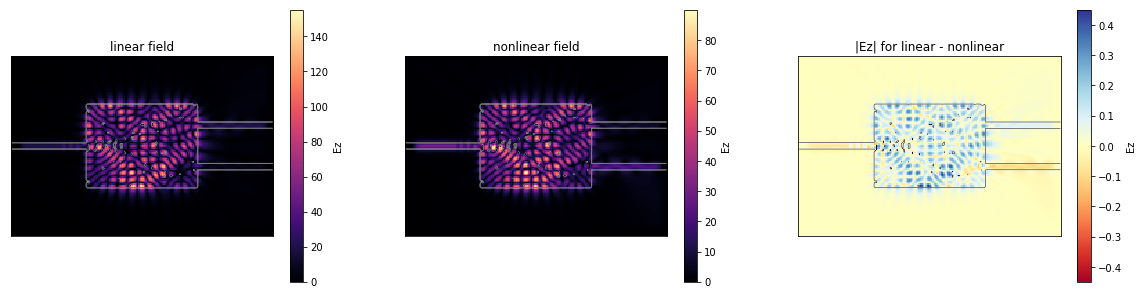

maximum refractive index shift of 0.0020395770698611315


In [45]:
# setup subplots
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))

# linear fields
simulation.plt_abs(ax=ax1)
ax1.set_title('linear field')

# nonlinear fields
simulation.plt_abs(ax=ax2, nl='True')
ax2.set_title('nonlinear field')

# difference
simulation.plt_diff(ax=ax3)
ax3.set_title('|Ez| for linear - nonlinear')

plt.show()

index_shift = simulation.compute_index_shift()
print('maximum refractive index shift of {}'.format(np.max(index_shift)))